# Preprocessing and Spectrogram Generation 

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from skimage.transform import resize

# All the audio files have a sample rate of 48000
sr = 48000

# All the audio clips are under 8 seconds
length = 8*sr

# ResNet50 input layer is 224 x 224 x 3, so I'm resizing the image to fit the first input dimension. 
dimensions = (224,224)

data_path = '../Data/'

#Determines the number of images to generate
num_of_images = 20

In [2]:
def generate_image(data,image_title,path):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(data, x_axis='time', y_axis='mel', sr=sr, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title=image_title)
    fig.savefig(path)

In [20]:
#Currently using a melspectrogram, Chromagram SFTF, and SFTF
#Possible other ideas: Chirplet
def generate_spectrograms(df,file_name):
    df['mspec_db'] = np.nan
    df['mspec_db'] = df['mspec_db'].astype(object)
    df['chroma_db'] = np.nan
    df['chroma_db'] = df['chroma_db'].astype(object)
    df['stft_db'] = np.nan
    df['stft_db'] = df['stft_db'].astype(object)

    for idx,row in df.iterrows():
        wav, sr = librosa.load(data_path + 'train/' + row['recording_id'] + '.flac', sr=None)
    
        # Slicing and centering spectograms 
        m = (int)((row['t_min'] + row['t_max'])*sr/2)
    
        l = (int)(m-(length/2))
        r = (int)(m+(length/2))
    
        #Assumes audio files are at least as long as length
        if l < 0:
            r += l
            l = 0
        elif r > len(wav):
            l -= r-len(wav)
            r = len(wav)
        
        #Melspectrogram
        mspec = librosa.feature.melspectrogram(y=wav[l:r], sr=sr, power=2.0)
        
        #Make Noisy Version
        mspec_noise = mspec.copy()
        noise_amp = 0.005*np.random.uniform()*np.amax(mspec_noise)
        mspec_noise = mspec_noise.astype('float64') + noise_amp * np.random.normal(size=mspec_noise.shape)
        
        mspec_noise_db = librosa.power_to_db(mspec_noise, ref=np.max)
        
        if idx < 10:
            mspec_db = librosa.power_to_db(mspec, ref=np.max)
            generate_image(mspec_db,'Mel-frequency Spectrogram',data_path+'Melspectrograms/'+file_name+'/'+str(idx)+'.png')
            generate_image(mspec_db,'Mel-frequency with Noise Spectrogram',data_path+'Melspectrograms_Noise/'+file_name+'/'+str(idx)+'.png')
        
        #mspec = (mspec - np.min(mspec))/np.max(mspec) normalizing but already on log scale
        mspec_noise_db = resize(mspec_noise_db, dimensions)
        df.at[idx, 'mspec_db'] = mspec_noise_db
        
        #Chroma
        chroma = librosa.feature.chroma_stft(y=wav[l:r], sr=sr)
                
        #Make Noisy Version
        chroma_noise = chroma.copy()
        noise_amp = 0.005*np.random.uniform()*np.amax(chroma_noise)
        chroma_noise = chroma_noise.astype('float64') + noise_amp * np.random.normal(size=chroma_noise.shape)
        
        chroma_noise_db = librosa.power_to_db(chroma_noise, ref=np.max)
        
        if idx < 10:
            chroma_db = librosa.power_to_db(chroma, ref=np.max)
            generate_image(chroma_db,'Chromagram',data_path+'Chromagram/'+file_name+'/'+str(idx)+'.png')
            generate_image(chroma_noise_db,'Chromagram with Noise',data_path+'Chromagram_Noise/'+file_name+'/'+str(idx)+'.png')
        
        #chroma = (chroma - np.min(chroma))/np.max(chroma)
        chroma_noise_db = resize(chroma_noise_db, dimensions)
        df.at[idx, 'chroma_db'] = chroma_noise_db
        
        #Short-time Fourier Transform
        stft = np.abs(librosa.stft(y=wav[l:r]))
        
        #Make Noisy Versions
        stft_noise = stft.copy()
        noise_amp = 0.005*np.random.uniform()*np.amax(stft_noise)
        stft_noise = stft_noise.astype('float64') + noise_amp * np.random.normal(size=stft_noise.shape)
        
        stft_noise_db = librosa.amplitude_to_db(stft_noise, ref=np.max)
        
        if idx < 10:
            stft_db = librosa.power_to_db(stft, ref=np.max)
            generate_image(stft_db,'Power Spectrogram',data_path+'stft/'+file_name+'/'+str(idx)+'.png')
            generate_image(stft_noise_db,'Power with Noise Spectrogram',data_path+'stft_Noise/'+file_name+'/'+str(idx)+'.png')
        
        #stft_db = (stft_db - np.min(stft_db))/np.max(stft_db)
        stft_noise_db = resize(stft_noise_db, dimensions)
        df.at[idx, 'stft_db'] = stft_noise_db
        
    df.to_csv(data_path+'csv/'+file_name+'_data.csv')

/home/craig/anaconda3/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: '../Data/train/006ab765f.flac'

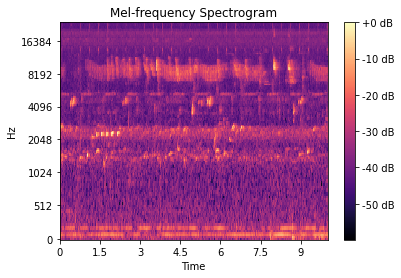

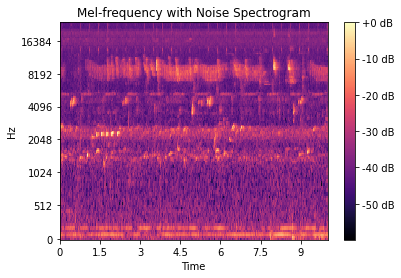

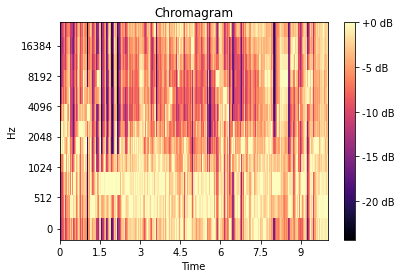

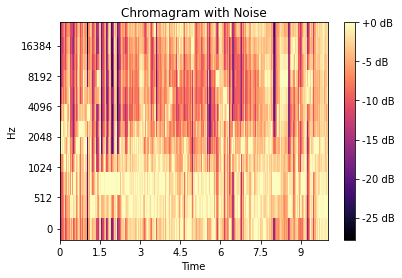

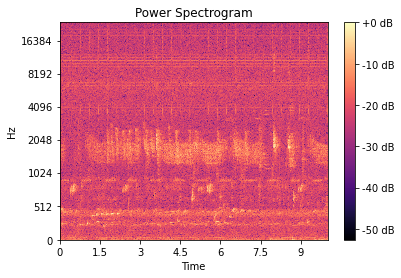

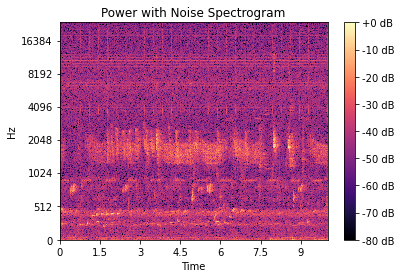

In [21]:
train_tp_df = pd.read_csv(data_path + 'train_tp.csv')
generate_spectrograms(train_tp_df,'train_tp')
train_fp_df = pd.read_csv(data_path + 'train_fp.csv')
generate_spectrograms(train_fp_df,'train_fp')